In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip


In [2]:
# ============================================
# Step 1: Import Libraries
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import os
import cv2
import zipfile
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# ============================================
# Step 2: Define Data Augmentations
# ============================================
# Training augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

# Validation augmentations (only normalization)
val_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
## ============================================
## Step 3:Define UNet Model (Encoder + Decoder)
## ============================================

## We are creating a custom Encoder class that loads a pretrained ResNet34 or ResNet50
## and extracts its layers to use in the U-Net architecture.

class ResNetEncoder(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True):
        super().__init__()
        if backbone_name == 'resnet34':
            backbone = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
            channels = [64, 64, 128, 256, 512]
        elif backbone_name == 'resnet50':
            backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError("Unsupported backbone")

        self.channels = channels
        self.initial = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

    def forward(self, x):
        x0 = self.initial(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        return x0, x1, x2, x3, x4

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x, skip):
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        if x.shape[2:] != skip.shape[2:]:
            skip = nn.functional.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True):
        super().__init__()
        self.encoder = ResNetEncoder(backbone_name, pretrained)
        channels = self.encoder.channels

        self.decoder4 = DecoderBlock(channels[4] + channels[3], 512)
        self.decoder3 = DecoderBlock(512 + channels[2], 256)
        self.decoder2 = DecoderBlock(256 + channels[1], 128)
        self.decoder1 = DecoderBlock(128 + channels[0], 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        out = self.final_conv(d1)
        out = nn.functional.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)
        return out

In [5]:
## ============================================
## Step 4: Loss Functions
## ============================================

# BCE + Dice Combined Loss (correctly without double sigmoid!)
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)  # no sigmoid here!
        probs = torch.sigmoid(logits)         # apply sigmoid separately for dice
        intersection = (probs * targets).sum()
        dice_loss = 1 - (2. * intersection + 1e-6) / (probs.sum() + targets.sum() + 1e-6)
        return bce_loss + dice_loss

# Lovasz Loss Utilities
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge_flat(logits, labels, ignore=None):
    if ignore is None:
        logits, labels = logits.view(-1), labels.view(-1)
    else:
        mask = (labels != ignore)
        logits, labels = logits[mask], labels[mask]
    signs = 2. * labels.float() - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss

class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        logits = logits.squeeze(1)  # (B,1,H,W) -> (B,H,W)
        targets = targets.squeeze(1)
        return lovasz_hinge_flat(logits, targets)


In [6]:
## ============================================
## Step 5: Load Data, Filter Non-Empty Masks, and Train/Val Split
## ============================================

# Unzip dataset (if needed)
zip_path = '/kaggle/input/tgs-salt-identification-challenge/train.zip'
output_dir = '/kaggle/working/train'

if not os.path.exists(output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("Train.zip extracted!")

# Set paths
image_dir = '/kaggle/working/train/images'
mask_dir = '/kaggle/working/train/masks'

# Load filenames
image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Full paths
image_paths = [os.path.join(image_dir, f) for f in image_filenames]
mask_paths = [os.path.join(mask_dir, f) for f in image_filenames]

# Helper: keep only images with some salt
def has_salt(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return mask.sum() > 0  # non-empty mask

# Filter training images to avoid empty masks
filtered = [(img, msk) for img, msk in zip(image_paths, mask_paths) if has_salt(msk)]

# Unpack
filtered_images, filtered_masks = zip(*filtered)

# Train/Validation Split (80/20)
train_images, val_images, train_masks, val_masks = train_test_split(
    filtered_images,
    filtered_masks,
    test_size=0.2,
    random_state=42
)

print(f"Training images (non-empty masks): {len(train_images)}")
print(f"Validation images: {len(val_images)}")


Train.zip extracted!
Training images (non-empty masks): 1950
Validation images: 488


In [7]:
# ============================================
# Step 6: Define SaltDataset and Create DataLoaders
# ============================================

# Data augmentations (already defined in Step 2, just reminding here)
# train_transform and val_transform

# Define the Dataset
class SaltDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        mask = mask.float() / 255.0  # <<<< 🌟 IMPORTANT: normalize mask to [0,1]

        return image, mask

# Create Datasets
train_dataset = SaltDataset(train_images, train_masks, transform=train_transform)
val_dataset = SaltDataset(val_images, val_masks, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print("✅ DataLoaders are ready!")

✅ DataLoaders are ready!


In [8]:
# ============================================
# Step 7: UNet Model
# ============================================
class ResNetEncoder(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True):
        super().__init__()
        if backbone_name == 'resnet34':
            backbone = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        elif backbone_name == 'resnet50':
            backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        else:
            raise ValueError("Unsupported backbone!")

        self.initial = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

    def forward(self, x):
        x0 = self.initial(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        return x0, x1, x2, x3, x4

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        if x.shape != skip.shape:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True):
        super().__init__()
        self.encoder = ResNetEncoder(backbone_name, pretrained)
        if backbone_name == 'resnet34':
            channels = [64, 64, 128, 256, 512]
        else:
            channels = [64, 256, 512, 1024, 2048]

        self.decoder4 = DecoderBlock(channels[4] + channels[3], 512)
        self.decoder3 = DecoderBlock(512 + channels[2], 256)
        self.decoder2 = DecoderBlock(256 + channels[1], 128)
        self.decoder1 = DecoderBlock(128 + channels[0], 64)
        self.final_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)
        return out


In [9]:
# ============================================
# Step 7b: Loss Functions
# ============================================

# BCE + Dice Combined Loss (correct)
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()  # input = raw logits

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)      # apply sigmoid for dice
        intersection = (probs * targets).sum()
        dice_loss = 1 - (2. * intersection + 1e-6) / (probs.sum() + targets.sum() + 1e-6)
        return bce_loss + dice_loss

# Lovasz Loss Utilities
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge_flat(logits, labels, ignore=None):
    if ignore is None:
        logits, labels = logits.view(-1), labels.view(-1)
    else:
        mask = (labels != ignore)
        logits, labels = logits[mask], labels[mask]
    signs = 2. * labels.float() - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, descending=True)
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss

class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, targets):
        preds = preds.squeeze(1)    # (B, 1, H, W) -> (B, H, W)
        targets = targets.squeeze(1)
        return lovasz_hinge_flat(preds, targets)

In [10]:
# ============================================
# Step 7C: Compute IoU and Train/Validate Loop
# ============================================

def compute_iou(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    targets = (targets > threshold).float()
    intersection = (preds * targets).sum(dim=(2, 3))
    union = (preds + targets - preds * targets).sum(dim=(2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

def train_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    model.to(device)
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += compute_iou(outputs, masks).item()
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val IoU: {val_iou:.4f}")

In [11]:
# ============================================
# Step 8: Experiment Models + Optimizers + Criteria
# ============================================
# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -----------------------------
# Experiment 1: UNet(ResNet34) + BCE+Dice Loss
# -----------------------------
model_exp1 = UNet(backbone_name='resnet34', pretrained=True).to(device)
optimizer_exp1 = optim.Adam(model_exp1.parameters(), lr=1e-4)
criterion_exp1 = BCEDiceLoss()

# -----------------------------
# Experiment 2: UNet(ResNet34) + Lovasz Loss
# -----------------------------
model_exp2 = UNet(backbone_name='resnet34', pretrained=True).to(device)
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=1e-4)
criterion_exp2 = LovaszLoss()

# -----------------------------
# Experiment 3: UNet(ResNet50) + BCE+Dice Loss
# -----------------------------
model_exp3 = UNet(backbone_name='resnet50', pretrained=True).to(device)
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=1e-4)
criterion_exp3 = BCEDiceLoss()

# -----------------------------
# Experiment 4: UNet(ResNet50) + Lovasz Loss
# -----------------------------
model_exp4 = UNet(backbone_name='resnet50', pretrained=True).to(device)
optimizer_exp4 = optim.Adam(model_exp4.parameters(), lr=1e-4)
criterion_exp4 = LovaszLoss()


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s] 


In [12]:
# ============================================
# Step 9: Train Experiments
# ============================================

# --- Train Experiment 1 ---
print("\nStarting Experiment 1: UNet(ResNet34) + BCE + Dice Loss")
train_validate(
    model=model_exp1,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_exp1,
    criterion=criterion_exp1,
    num_epochs=20,   # You can change to 50 if you want
    device=device
)


Starting Experiment 1: UNet(ResNet34) + BCE + Dice Loss
Epoch 1/20 - Train Loss: 1.0484 - Val Loss: 0.7678 - Val IoU: 0.3848
Epoch 2/20 - Train Loss: 0.6452 - Val Loss: 0.5159 - Val IoU: 0.5490
Epoch 3/20 - Train Loss: 0.5318 - Val Loss: 0.4475 - Val IoU: 0.5851
Epoch 4/20 - Train Loss: 0.4532 - Val Loss: 0.4052 - Val IoU: 0.6007
Epoch 5/20 - Train Loss: 0.4238 - Val Loss: 0.4017 - Val IoU: 0.6247
Epoch 6/20 - Train Loss: 0.3929 - Val Loss: 0.4001 - Val IoU: 0.6504
Epoch 7/20 - Train Loss: 0.3634 - Val Loss: 0.3480 - Val IoU: 0.6648
Epoch 8/20 - Train Loss: 0.3475 - Val Loss: 0.3252 - Val IoU: 0.6932
Epoch 9/20 - Train Loss: 0.3024 - Val Loss: 0.3813 - Val IoU: 0.6801
Epoch 10/20 - Train Loss: 0.3155 - Val Loss: 0.3468 - Val IoU: 0.6726
Epoch 11/20 - Train Loss: 0.3017 - Val Loss: 0.2929 - Val IoU: 0.7105
Epoch 12/20 - Train Loss: 0.2817 - Val Loss: 0.3173 - Val IoU: 0.7037
Epoch 13/20 - Train Loss: 0.2927 - Val Loss: 0.3315 - Val IoU: 0.6809
Epoch 14/20 - Train Loss: 0.2694 - Val Los

In [13]:
# --- Train Experiment 2 ---
print("\nStarting Experiment 2: UNet(ResNet34) + Lovasz Loss")
train_validate(
    model=model_exp2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_exp2,
    criterion=criterion_exp2,
    num_epochs=20,
    device=device
)


Starting Experiment 2: UNet(ResNet34) + Lovasz Loss
Epoch 1/20 - Train Loss: 0.9656 - Val Loss: 0.7976 - Val IoU: 0.5095
Epoch 2/20 - Train Loss: 0.7672 - Val Loss: 0.5991 - Val IoU: 0.5831
Epoch 3/20 - Train Loss: 0.6104 - Val Loss: 0.5810 - Val IoU: 0.5880
Epoch 4/20 - Train Loss: 0.5737 - Val Loss: 0.4517 - Val IoU: 0.6340
Epoch 5/20 - Train Loss: 0.5080 - Val Loss: 0.4299 - Val IoU: 0.6600
Epoch 6/20 - Train Loss: 0.4389 - Val Loss: 0.4490 - Val IoU: 0.6402
Epoch 7/20 - Train Loss: 0.4567 - Val Loss: 0.3653 - Val IoU: 0.7026
Epoch 8/20 - Train Loss: 0.3959 - Val Loss: 0.4053 - Val IoU: 0.6903
Epoch 9/20 - Train Loss: 0.3897 - Val Loss: 0.3598 - Val IoU: 0.7071
Epoch 10/20 - Train Loss: 0.3603 - Val Loss: 0.3298 - Val IoU: 0.7203
Epoch 11/20 - Train Loss: 0.3417 - Val Loss: 0.3694 - Val IoU: 0.7280
Epoch 12/20 - Train Loss: 0.3431 - Val Loss: 0.3501 - Val IoU: 0.7262
Epoch 13/20 - Train Loss: 0.3597 - Val Loss: 0.2957 - Val IoU: 0.7360
Epoch 14/20 - Train Loss: 0.3192 - Val Loss: 0

In [14]:
# --- Train Experiment 3 ---
print("\nStarting Experiment 3: UNet(ResNet50) + BCE + Dice Loss")
train_validate(
    model=model_exp3,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_exp3,
    criterion=criterion_exp3,
    num_epochs=20,
    device=device
)


Starting Experiment 3: UNet(ResNet50) + BCE + Dice Loss
Epoch 1/20 - Train Loss: 0.9505 - Val Loss: 0.6354 - Val IoU: 0.4907
Epoch 2/20 - Train Loss: 0.5719 - Val Loss: 0.4974 - Val IoU: 0.5728
Epoch 3/20 - Train Loss: 0.4743 - Val Loss: 0.4099 - Val IoU: 0.6219
Epoch 4/20 - Train Loss: 0.4129 - Val Loss: 0.3609 - Val IoU: 0.6436
Epoch 5/20 - Train Loss: 0.3531 - Val Loss: 0.3187 - Val IoU: 0.6417
Epoch 6/20 - Train Loss: 0.3320 - Val Loss: 0.3815 - Val IoU: 0.5950
Epoch 7/20 - Train Loss: 0.3224 - Val Loss: 0.2886 - Val IoU: 0.6865
Epoch 8/20 - Train Loss: 0.2945 - Val Loss: 0.3114 - Val IoU: 0.6579
Epoch 9/20 - Train Loss: 0.2837 - Val Loss: 0.2550 - Val IoU: 0.7132
Epoch 10/20 - Train Loss: 0.2902 - Val Loss: 0.2979 - Val IoU: 0.7158
Epoch 11/20 - Train Loss: 0.2604 - Val Loss: 0.2569 - Val IoU: 0.7121
Epoch 12/20 - Train Loss: 0.2350 - Val Loss: 0.2653 - Val IoU: 0.7210
Epoch 13/20 - Train Loss: 0.2317 - Val Loss: 0.2380 - Val IoU: 0.7274
Epoch 14/20 - Train Loss: 0.2244 - Val Los

In [15]:
# --- Train Experiment 4 ---
print("\nStarting Experiment 4: UNet(ResNet50) + Lovasz Loss")
train_validate(
    model=model_exp4,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_exp4,
    criterion=criterion_exp4,
    num_epochs=20,
    device=device
)


Starting Experiment 4: UNet(ResNet50) + Lovasz Loss
Epoch 1/20 - Train Loss: 0.9723 - Val Loss: 0.9487 - Val IoU: 0.5095
Epoch 2/20 - Train Loss: 0.7638 - Val Loss: 0.7633 - Val IoU: 0.5560
Epoch 3/20 - Train Loss: 0.5894 - Val Loss: 0.4924 - Val IoU: 0.5800
Epoch 4/20 - Train Loss: 0.5148 - Val Loss: 0.4568 - Val IoU: 0.6396
Epoch 5/20 - Train Loss: 0.4296 - Val Loss: 0.3783 - Val IoU: 0.6748
Epoch 6/20 - Train Loss: 0.3926 - Val Loss: 0.3779 - Val IoU: 0.6699
Epoch 7/20 - Train Loss: 0.3799 - Val Loss: 0.3693 - Val IoU: 0.6913
Epoch 8/20 - Train Loss: 0.3590 - Val Loss: 0.3624 - Val IoU: 0.7043
Epoch 9/20 - Train Loss: 0.3327 - Val Loss: 0.3235 - Val IoU: 0.7145
Epoch 10/20 - Train Loss: 0.3276 - Val Loss: 0.3091 - Val IoU: 0.7329
Epoch 11/20 - Train Loss: 0.2976 - Val Loss: 0.3140 - Val IoU: 0.7334
Epoch 12/20 - Train Loss: 0.2921 - Val Loss: 0.3355 - Val IoU: 0.7384
Epoch 13/20 - Train Loss: 0.3034 - Val Loss: 0.3138 - Val IoU: 0.7316
Epoch 14/20 - Train Loss: 0.2854 - Val Loss: 0

In [16]:
import os

# Create folders for models and results
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [17]:
# Save the trained models
torch.save(model_exp1.state_dict(), "models/unet_resnet34_bce_dice.pth")
torch.save(model_exp2.state_dict(), "models/unet_resnet34_lovasz.pth")
torch.save(model_exp3.state_dict(), "models/unet_resnet50_bce_dice.pth")
torch.save(model_exp4.state_dict(), "models/unet_resnet50_lovasz.pth")

print("✅ Models saved successfully!")

✅ Models saved successfully!


In [18]:
#Experiment 1
# Create epoch list
epochs = list(range(1, 21))

# Fill the training logs manually from your print outputs
train_loss_exp1 = [
    1.0163, 0.6259, 0.5113, 0.5176, 0.4305, 0.3902, 0.3634, 
    0.3231, 0.3197, 0.3072, 0.2836, 0.2774, 0.2894, 0.2896, 
    0.2678, 0.2591, 0.2376, 0.2336, 0.2305, 0.2256
]

val_loss_exp1 = [
    0.7548, 0.5101, 0.4145, 0.3450, 0.3221, 0.3102, 0.2738, 
    0.2846, 0.2707, 0.2458, 0.2368, 0.2322, 0.2603, 0.2372, 
    0.2211, 0.2736, 0.2069, 0.2045, 0.1980, 0.2031
]

val_iou_exp1 = [
    0.3696, 0.5240, 0.5681, 0.6100, 0.6264, 0.6492, 0.6654, 
    0.6674, 0.6864, 0.6888, 0.7091, 0.7104, 0.7054, 0.7014, 
    0.7164, 0.6747, 0.7204, 0.7329, 0.7300, 0.7357
]


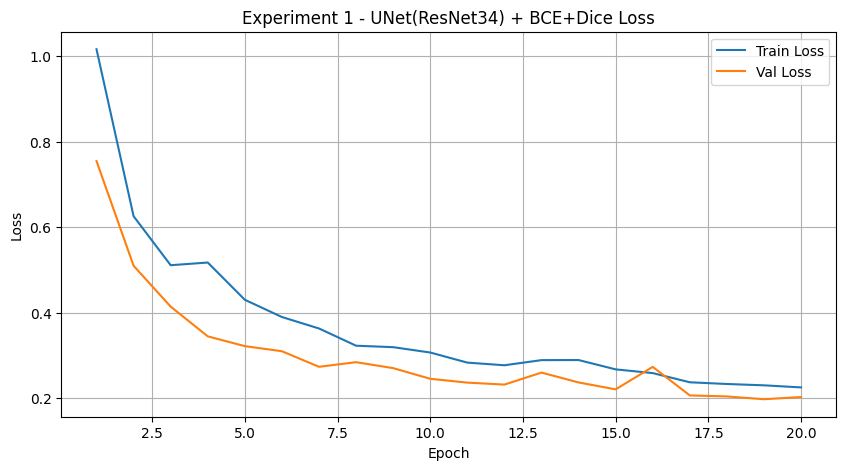

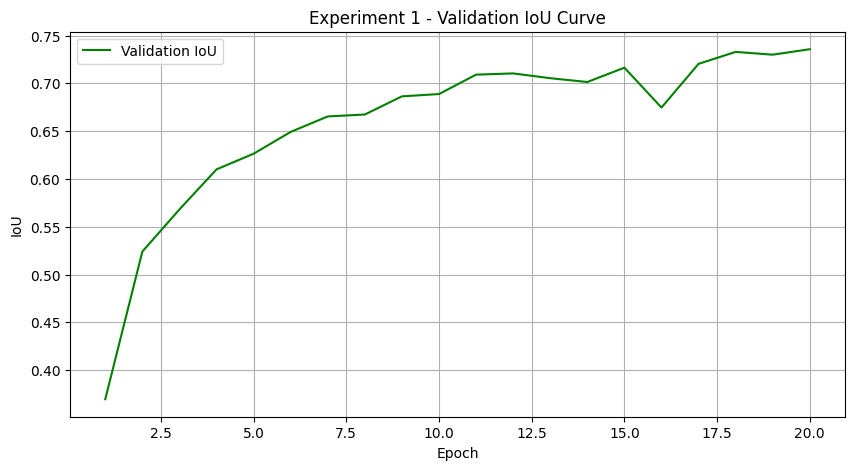

✅ Training curves for Experiment 1 saved successfully!


In [19]:
import matplotlib.pyplot as plt

# Loss Plot
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss_exp1, label="Train Loss")
plt.plot(epochs, val_loss_exp1, label="Val Loss")
plt.title("Experiment 1 - UNet(ResNet34) + BCE+Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("results/loss_curve_exp1.png")
plt.show()

# IoU Plot
plt.figure(figsize=(10,5))
plt.plot(epochs, val_iou_exp1, label="Validation IoU", color='green')
plt.title("Experiment 1 - Validation IoU Curve")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.savefig("results/iou_curve_exp1.png")
plt.show()

print("✅ Training curves for Experiment 1 saved successfully!")

In [20]:
# Experiment 2
train_loss_exp2 = [
    0.9965, 0.7645, 0.6285, 0.5440, 0.5043, 0.4367, 0.4388,
    0.4459, 0.4095, 0.3730, 0.3482, 0.3581, 0.3585, 0.3320,
    0.3223, 0.3236, 0.3205, 0.3046, 0.3315, 0.3305
]

val_loss_exp2 = [
    0.9232, 0.5998, 0.4864, 0.5065, 0.3748, 0.2971, 0.3458,
    0.3727, 0.2981, 0.2794, 0.2823, 0.3161, 0.2743, 0.3007,
    0.2798, 0.2907, 0.2760, 0.2733, 0.3127, 0.2643
]

val_iou_exp2 = [
    0.3794, 0.5189, 0.5794, 0.6136, 0.6627, 0.6776, 0.6700,
    0.6837, 0.6993, 0.7146, 0.7168, 0.7001, 0.6998, 0.7140,
    0.7187, 0.7106, 0.7386, 0.7234, 0.7459, 0.7322
]

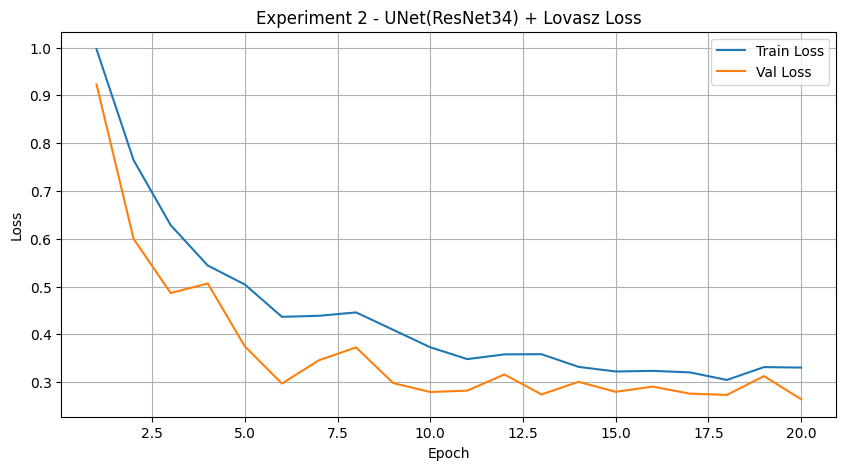

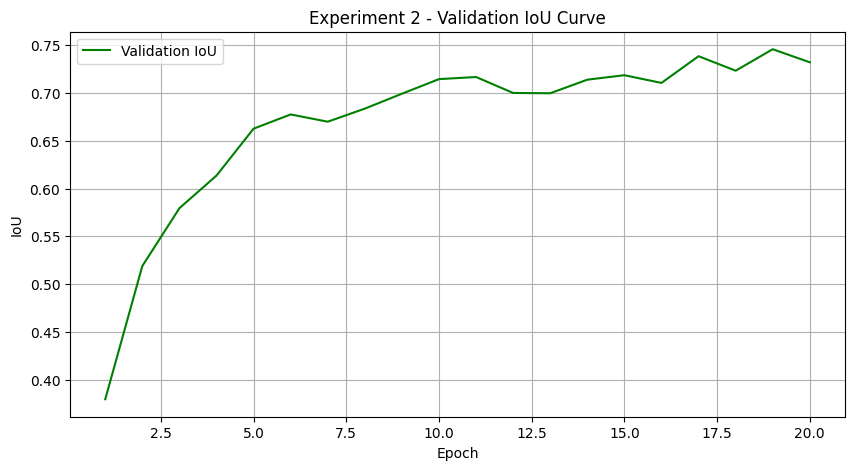

In [21]:
#Plotting for Experiment 2: UNet(ResNet34) + Lovasz Loss
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Plot Loss Curves
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss_exp2, label="Train Loss")
plt.plot(epochs, val_loss_exp2, label="Val Loss")
plt.title("Experiment 2 - UNet(ResNet34) + Lovasz Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("results/loss_curve_exp2.png")
plt.show()

# Plot IoU Curve
plt.figure(figsize=(10,5))
plt.plot(epochs, val_iou_exp2, label="Validation IoU", color='green')
plt.title("Experiment 2 - Validation IoU Curve")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.savefig("results/iou_curve_exp2.png")
plt.show()

In [22]:
# Experiment 3
train_loss_exp3 = [
    0.9474, 0.5695, 0.4564, 0.4203, 0.3662, 0.3258, 0.3058,
    0.2974, 0.2618, 0.2527, 0.2441, 0.2313, 0.2355, 0.2208,
    0.2273, 0.2275, 0.2033, 0.1982, 0.1949, 0.2061
]

val_loss_exp3 = [
    0.6753, 0.4089, 0.3959, 0.4137, 0.2865, 0.2976, 0.2693,
    0.2517, 0.2243, 0.2310, 0.2137, 0.2242, 0.2187, 0.2219,
    0.2258, 0.2085, 0.2008, 0.1889, 0.2047, 0.2109
]

val_iou_exp3 = [
    0.4958, 0.5510, 0.6212, 0.6359, 0.6500, 0.6792, 0.6876,
    0.6913, 0.6884, 0.7136, 0.7082, 0.7052, 0.7154, 0.7157,
    0.7300, 0.7170, 0.7442, 0.7430, 0.7466, 0.7533
]

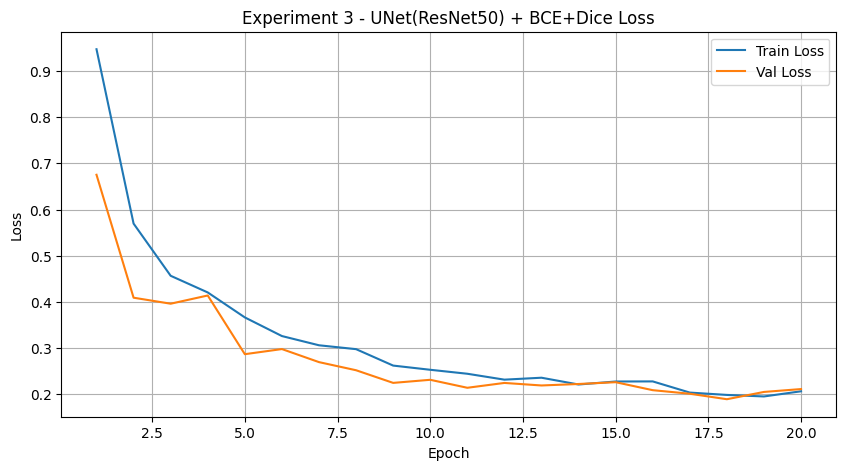

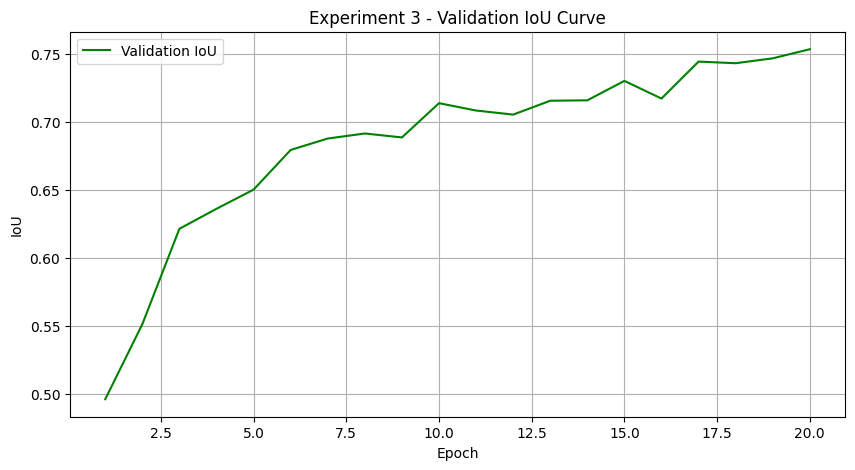

In [23]:
# Plotting for Experiment 3: UNet(ResNet50) + BCE + Dice Loss
# Plot Loss Curves
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss_exp3, label="Train Loss")
plt.plot(epochs, val_loss_exp3, label="Val Loss")
plt.title("Experiment 3 - UNet(ResNet50) + BCE+Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("results/loss_curve_exp3.png")
plt.show()

# Plot IoU Curve
plt.figure(figsize=(10,5))
plt.plot(epochs, val_iou_exp3, label="Validation IoU", color='green')
plt.title("Experiment 3 - Validation IoU Curve")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.savefig("results/iou_curve_exp3.png")
plt.show()

In [24]:
# Experiment 4
train_loss_exp4 = [
    0.9243, 0.6671, 0.5190, 0.4612, 0.4140, 0.3938, 0.3730,
    0.3602, 0.3246, 0.3111, 0.3129, 0.2929, 0.2684, 0.2916,
    0.2838, 0.2669, 0.2920, 0.2624, 0.2550, 0.2553
]

val_loss_exp4 = [
    0.6712, 0.5267, 0.5704, 0.3667, 0.3349, 0.3177, 0.3021,
    0.2918, 0.2783, 0.2806, 0.2648, 0.2679, 0.2470, 0.2489,
    0.2451, 0.2787, 0.2517, 0.2383, 0.2524, 0.2354
]

val_iou_exp4 = [
    0.5303, 0.5673, 0.6094, 0.6451, 0.6532, 0.6786, 0.7051,
    0.6999, 0.7206, 0.7263, 0.7165, 0.7278, 0.7288, 0.7373,
    0.7227, 0.7306, 0.7332, 0.7385, 0.7478, 0.7480
]

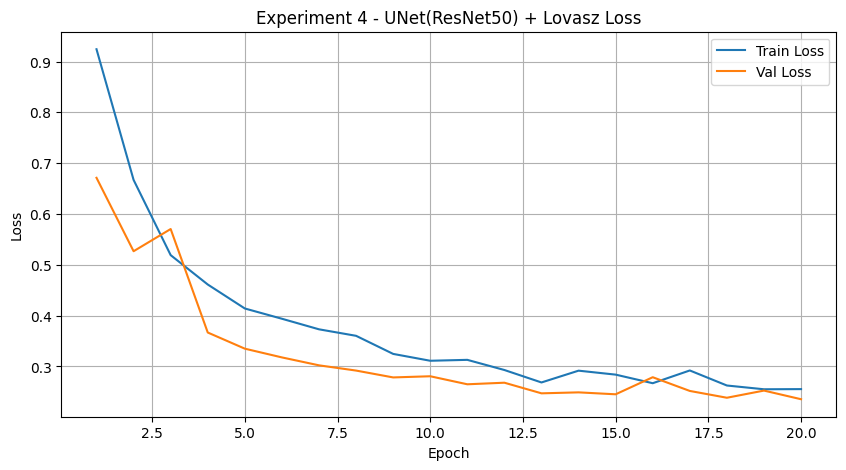

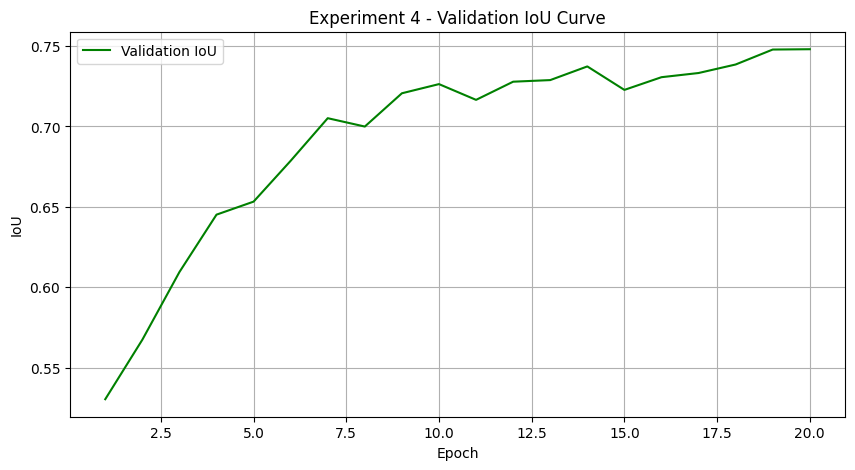

In [25]:
#Plotting for Experiment 4: UNet(ResNet50) + Lovasz Loss
# Plot Loss Curves
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss_exp4, label="Train Loss")
plt.plot(epochs, val_loss_exp4, label="Val Loss")
plt.title("Experiment 4 - UNet(ResNet50) + Lovasz Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("results/loss_curve_exp4.png")
plt.show()

# Plot IoU Curve
plt.figure(figsize=(10,5))
plt.plot(epochs, val_iou_exp4, label="Validation IoU", color='green')
plt.title("Experiment 4 - Validation IoU Curve")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.savefig("results/iou_curve_exp4.png")
plt.show()

In [29]:
# Zip the models folder
!zip -r models.zip /kaggle/working/models

# Zip the results folder
!zip -r results.zip /kaggle/working/results

!mv /kaggle/working/models.zip /kaggle/working/


updating: kaggle/working/models/ (stored 0%)
updating: kaggle/working/models/unet_resnet50_bce_dice.pth (deflated 8%)
updating: kaggle/working/models/unet_resnet50_lovasz.pth (deflated 8%)
updating: kaggle/working/models/unet_resnet34_bce_dice.pth (deflated 7%)
updating: kaggle/working/models/unet_resnet34_lovasz.pth (deflated 7%)
updating: kaggle/working/results/ (stored 0%)
updating: kaggle/working/results/iou_curve_exp2.png (deflated 13%)
updating: kaggle/working/results/iou_curve_exp1.png (deflated 12%)
updating: kaggle/working/results/iou_curve_exp3.png (deflated 12%)
updating: kaggle/working/results/loss_curve_exp4.png (deflated 9%)
updating: kaggle/working/results/loss_curve_exp3.png (deflated 10%)
updating: kaggle/working/results/iou_curve_exp4.png (deflated 12%)
updating: kaggle/working/results/loss_curve_exp1.png (deflated 9%)
updating: kaggle/working/results/loss_curve_exp2.png (deflated 8%)
mv: '/kaggle/working/models.zip' and '/kaggle/working/models.zip' are the same file
